# Part One: Data Cleaning

In [1]:
## Create SparkContext and SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Amazon") \
     .getOrCreate()
sc = spark.sparkContext

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql.functions import isnull, when, count, col

In [4]:
#load trip file into a DataFrame
df = spark.read\
  .format('parquet')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://amazon-reviews-pds/parquet/')

In [5]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)



In [6]:
print("Out data has {0} records and {1} columns".format(df.count(),len(df.columns)))

Out data has 160796570 records and 16 columns


In [5]:
#change data type
from pyspark.sql.functions import col
df1 = df
df1 = df.withColumn("star_rating", df["star_rating"].cast("double"))
df1 = df.withColumn("year", df["year"].cast("int"))
df1 = df.withColumn("helpful_votes", df["helpful_votes"].cast("int"))
df1 = df.withColumn("total_votes", df["total_votes"].cast("int"))
df1 = df.withColumn("star_rating", df["star_rating"].cast("int"))

In [8]:
#check missing values
df1.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+-----------+---------+----------+--------------+-------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+----+----------------+
|marketplace|customer_id|review_id|product_id|product_parent|product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline|review_body|review_date|year|product_category|
+-----------+-----------+---------+----------+--------------+-------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+----+----------------+
|          0|          0|        0|         0|             0|            0|          0|            0|          0|   0|                0|            320|       6798|          0|   0|               0|
+-----------+-----------+---------+----------+--------------+-------------+-----------+-------------+-----------+----+-----------------+---------------+-----------+-----------+----+----------------+



In [6]:
# drop rows with missing values
df1 = df1.where(col("review_headline").isNotNull())
df1 = df1.where(col("review_body").isNotNull())

In [10]:
print("Out data has {0} records and {1} columns".format(df1.count(),len(df1.columns)))

Out data has 160789452 records and 16 columns


# Part Two: Exploratory Analysis

In this section, our group used Spark SQL to see the distribution of our dataset. Also, we want to look at what kind of product or what kind of customers will have/give higher star ratings.

In [7]:
df1.createOrReplaceTempView("amazon")

## 2.1 Distribution of the dataset

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


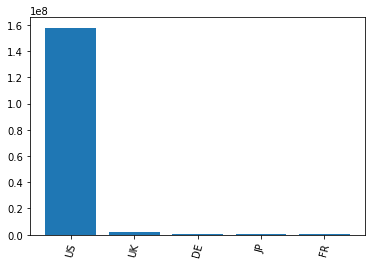

In [18]:
## Distribution of the market place
di_ma = spark.sql("""
                  SELECT marketplace, COUNT(marketplace) count 
                  FROM amazon
                  GROUP BY marketplace 
                  ORDER BY count DESC""").toPandas()
plt.bar(di_ma['marketplace'],di_ma ['count'])
plt.xticks(rotation=75)
plt.show()

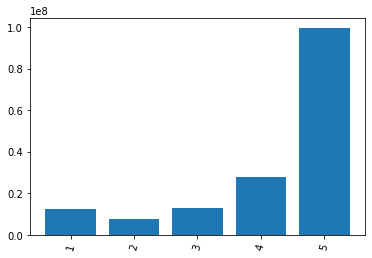

In [21]:
## Distribution of the overall star rating
di_star = spark.sql("""
                    SELECT star_rating, count(star_rating) count_star 
                    FROM amazon
                    GROUP BY star_rating
                    ORDER BY count_star DESC
                    """).toPandas()
plt.bar(di_star['star_rating'],di_star['count_star'])
plt.xticks(rotation=75)
plt.show()

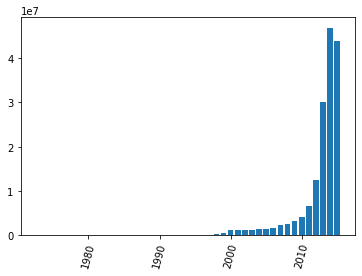

In [26]:
## Distribution of the overall star rating
di_star = spark.sql("""
                    SELECT year, count(star_rating) count_star 
                    FROM amazon
                    GROUP BY year
                    ORDER BY year
                    """).toPandas()
plt.bar(di_star['year'],di_star['count_star'])
plt.xticks(rotation=75)
plt.show()

There are some abnormal recordings before year 1995, we decide to drop these rows in the later analysis.

In [11]:
df1=df1.filter(col('year') >= 1995)
df1.createOrReplaceTempView("amazon")

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


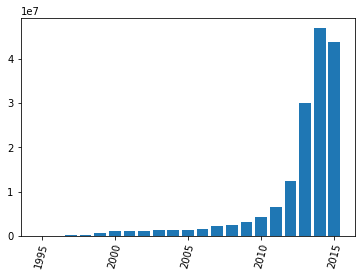

In [10]:
## Distribution of the overall star rating
di_star = spark.sql("""
                    SELECT year, count(star_rating) count_star 
                    FROM amazon
                    GROUP BY year
                    ORDER BY year
                    """).toPandas()
plt.bar(di_star['year'],di_star['count_star'])
plt.xticks(rotation=75)
plt.show()

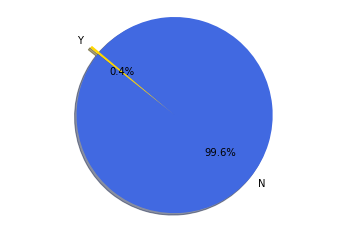

In [20]:
## proportion of vine member
pro_vine = spark.sql("""
                    SELECT vine, count(vine) * 100 / (SELECT COUNT(*) FROM amazon)  vine_percent
                    FROM amazon
                    GROUP BY vine
                    """).toPandas()

#plot data
labels = 'Y', 'N'
sizes = [pro_vine["vine_percent"][0], pro_vine["vine_percent"][1]]
colors = ['gold', 'royalblue']
explode = (0.1, 0)  # explode 1st slice

#plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

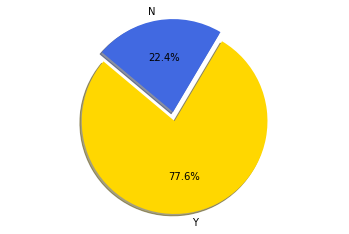

In [22]:
## proportion of vine member
pro_vine = spark.sql("""
                    SELECT verified_purchase, count(verified_purchase) * 100 / (SELECT COUNT(*) FROM amazon)  verified_percent
                    FROM amazon
                    GROUP BY verified_purchase
                    """).toPandas()

#plot data
labels = 'Y', 'N'
sizes = [pro_vine["verified_percent"][0], pro_vine["verified_percent"][1]]
colors = ['gold', 'royalblue']
explode = (0.1, 0)  # explode 1st slice

#plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# 2.2 How do ratings vary with verified purchase, Vine membership, Marketplace and over time?

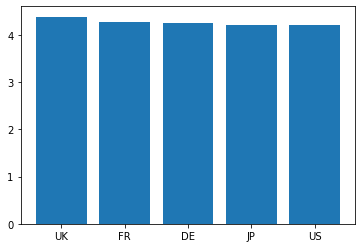

In [11]:
mkt_rat = spark.sql("""
             SELECT marketplace, 
             CAST(AVG(star_rating) as decimal (3,2)) avg_rating
             FROM amazon
             GROUP BY marketplace 
             ORDER BY avg_rating DESC""").toPandas()
plt.bar(mkt_rat['marketplace'],mkt_rat['avg_rating'])
plt.show()

UK has the highest average rating while US has the lowest one.

In [9]:
spark.sql("""
        SELECT vine, 
        CAST(AVG(CAST(star_rating AS decimal(5,4))) AS decimal (3,2)) avg_rating
        FROM amazon
        GROUP BY 1 
        ORDER BY 2 DESC""").show()

+----+----------+
|vine|avg_rating|
+----+----------+
|   N|      4.21|
|   Y|      4.08|
+----+----------+



Vine members tend to give lower ratings compared to non-members.

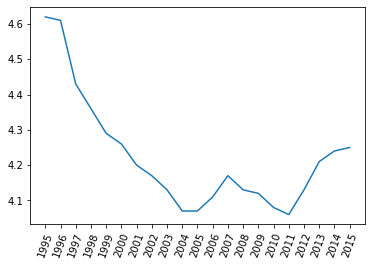

In [31]:
year_rat = spark.sql('''
SELECT year, 
CAST(AVG(CAST(star_rating AS decimal(5,4))) AS decimal (3,2)) avg_rating
FROM amazon
GROUP BY year
ORDER BY year DESC
''').toPandas()
plt.plot(year_rat["year"],year_rat["avg_rating"])
temp_list = list(year_rat["year"])
plt.xticks(year_rat["year"],temp_list, rotation=70)
plt.show()

In [10]:
spark.sql("""
            SELECT verified_purchase, 
            CAST(AVG(CAST(star_rating AS decimal(5,4))) AS decimal (3,2)) avg_rating
            FROM amazon
            GROUP BY 1 
            ORDER BY 2""").show()

+-----------------+----------+
|verified_purchase|avg_rating|
+-----------------+----------+
|                N|      4.11|
|                Y|      4.24|
+-----------------+----------+



In [14]:
spark.sql('''
SELECT product_category, 
CAST(AVG(CAST(star_rating AS decimal(5,4))) AS decimal (3,2)) avg_rating,
COUNT(*) count
FROM amazon
GROUP BY 1 
ORDER BY 2 DESC
''').show(10)

+--------------------+----------+--------+
|    product_category|avg_rating|   count|
+--------------------+----------+--------+
|           Gift_Card|      4.73|  149085|
|Digital_Music_Pur...|      4.64| 1852136|
|               Music|      4.44| 6177621|
|               Books|      4.34|20725905|
|             Grocery|      4.31| 2402412|
|           Video_DVD|      4.31| 7135754|
|Digital_Ebook_Pur...|      4.31|19180684|
|               Tools|      4.26| 1748563|
| Musical_Instruments|      4.25|  920676|
|          Automotive|      4.25| 3515964|
+--------------------+----------+--------+
only showing top 10 rows



In [37]:
spark.sql('''
SELECT product_category, 
CAST(AVG(CAST(star_rating AS decimal(5,4))) AS decimal (3,2)) avg_rating,
COUNT(*) count
FROM amazon
GROUP BY 1 
ORDER BY 2 DESC
''').show(50)

+--------------------+----------+--------+
|    product_category|avg_rating|   count|
+--------------------+----------+--------+
|           Gift_Card|      4.73|  149085|
|Digital_Music_Pur...|      4.64| 1852136|
|               Music|      4.44| 6177621|
|               Books|      4.34|20725905|
|             Grocery|      4.31| 2402412|
|           Video_DVD|      4.31| 7135754|
|Digital_Ebook_Pur...|      4.31|19180684|
|               Tools|      4.26| 1748563|
| Musical_Instruments|      4.25|  920676|
|          Automotive|      4.25| 3515964|
|               Shoes|      4.24| 4379038|
|            Outdoors|      4.24| 2305467|
|              Sports|      4.23| 4859725|
|                Toys|      4.22| 4981218|
|             Luggage|      4.22|  349108|
|Digital_Video_Dow...|      4.21| 5173648|
|             Kitchen|      4.21| 4882582|
|               Video|      4.20|  437408|
|              Beauty|      4.19| 5115351|
|    Home_Improvement|      4.18| 2640482|
|          

## 2.3 How do review helpfulness vary?

In [11]:
spark.sql('''
SELECT vine, 
CAST(AVG(CAST(helpful_votes AS decimal(5,4))) AS decimal (3,2)) avg_help,
COUNT(*) count
FROM amazon
GROUP BY 1 
ORDER BY 2 DESC
''').show()

+----+--------+---------+
|vine|avg_help|    count|
+----+--------+---------+
|   Y|    1.14|   680261|
|   N|    0.78|160109191|
+----+--------+---------+



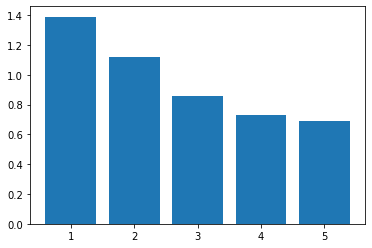

In [41]:
star_help=spark.sql('''
SELECT star_rating, 
CAST(AVG(CAST(helpful_votes AS decimal(5,4))) AS decimal (3,2)) avg_help
FROM amazon
GROUP BY 1 
ORDER BY 1 DESC
''').toPandas()
plt.bar(star_help['star_rating'],star_help['avg_help'])
plt.show()

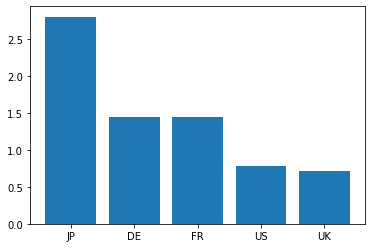

In [52]:
star_mkt=spark.sql('''
SELECT marketplace,
CAST(AVG(CAST(helpful_votes AS decimal(5,4))) AS decimal (3,2)) avg_help
FROM amazon
GROUP BY 1 
ORDER BY 2 DESC
''').toPandas()
plt.bar(star_mkt['marketplace'],star_mkt['avg_help'])
plt.show()

In [13]:
spark.sql('''
SELECT verified_purchase, 
CAST(AVG(CAST(helpful_votes AS decimal(5,4))) AS decimal (3,2)) avg_help,
COUNT(*) count
FROM amazon
GROUP BY 1 
ORDER BY 1 DESC
''').show()

+-----------------+--------+---------+
|verified_purchase|avg_help|    count|
+-----------------+--------+---------+
|                Y|    0.61|124744037|
|                N|    1.44| 36045415|
+-----------------+--------+---------+



In [42]:
spark.sql('''
SELECT product_category, 
CAST(AVG(CAST(helpful_votes AS decimal(5,4))) AS decimal (3,2)) avg_help,
COUNT(*) count
FROM amazon
GROUP BY 1 
ORDER BY 2 DESC
''').show(15)

+--------------------+--------+--------+
|    product_category|avg_help|   count|
+--------------------+--------+--------+
|               Video|    2.07|  437408|
|               Music|    1.50| 6177622|
|            Software|    1.42|  342133|
|               Books|    1.40|20725905|
|    Major_Appliances|    1.36|   96894|
|           Video_DVD|    1.21| 7135754|
|Personal_Care_App...|    1.17|   86686|
|  Home_Entertainment|    1.01|  743684|
|         Video_Games|    0.92| 1808434|
|           Furniture|    0.92|  792111|
|              Camera|    0.89| 1838692|
| Musical_Instruments|    0.88|  920676|
|Health_&_Personal...|    0.87| 5332715|
|     Lawn_and_Garden|    0.82| 2559115|
|             Luggage|    0.80|  349108|
+--------------------+--------+--------+
only showing top 15 rows



# Part Three: Word Cloud

In this part, we want to look at the common words that occured in high rating and low rating product reviews. We looked at two high rating categories and two low rating catogires for comparison.

In [12]:
df1.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)



In [13]:
df1.select('marketplace').distinct().show()

+-----------+
|marketplace|
+-----------+
|         DE|
|         US|
|         FR|
|         UK|
|         JP|
+-----------+



In [14]:
data = df1[(df1.marketplace == 'US')]

In [15]:
data.createOrReplaceTempView("df_tbl")

In [16]:
spark.sql('''
select product_category, count(*),CAST(AVG(CAST(star_rating AS decimal(5,4))) AS decimal (3,2)) avg_rating
from df_tbl
group by product_category
order by 3 desc
''').show(50)

+--------------------+--------+----------+
|    product_category|count(1)|avg_rating|
+--------------------+--------+----------+
|           Gift_Card|  149085|      4.73|
|Digital_Music_Pur...| 1796702|      4.64|
|               Music| 5530130|      4.44|
|               Books|20369876|      4.34|
|Digital_Ebook_Pur...|18871224|      4.31|
|             Grocery| 2402410|      4.31|
|           Video_DVD| 6165962|      4.31|
|               Tools| 1748563|      4.26|
|          Automotive| 3514653|      4.25|
| Musical_Instruments|  915675|      4.25|
|            Outdoors| 2305467|      4.24|
|               Shoes| 4373862|      4.24|
|              Sports| 4854167|      4.23|
|             Luggage|  348711|      4.22|
|Digital_Video_Dow...| 5115150|      4.21|
|                Toys| 4921643|      4.21|
|             Kitchen| 4882060|      4.21|
|               Video|  427318|      4.20|
|              Beauty| 5115348|      4.19|
|                Home| 6223025|      4.18|
|    Home_I

In [17]:
pip install wordcloud

     |████████████████████████████████| 368kB 41.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [19]:
#gift card 
GIFT = spark.sql('''
select review_body 
from df_tbl
where product_category = "Gift_Card"
''').collect()

In [20]:
text = " ".join(str(review) for review in GIFT) 
print ("There are {} words in the combination of all review.".format(len(text)))

There are 22037531 words in the combination of all review.


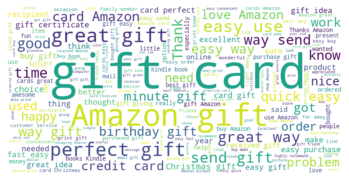

In [21]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Row review_body","review_body","Row","br","a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400,stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
wordcloud.to_file("giftcard.png")

In [23]:
#Books
BOOK = spark.sql('''
select review_body 
from df_tbl
where product_category = "Books"
limit 200000
''').collect()

In [24]:
books = " ".join(str(review) for review in BOOK) 
print ("There are {} words in the combination of all review.".format(len(books)))

There are 120522859 words in the combination of all review.


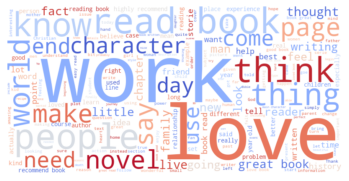

In [25]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["author","way","story","time","life","Row review_body","review_body","Row","br","a", "about", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"])

# Generate a word cloud image
wordcloudbook = WordCloud(width=800, height=400,stopwords=stopwords, background_color="white",colormap="coolwarm").generate(books)

plt.imshow(wordcloudbook, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
wordcloudbook.to_file("Book.png")

In [27]:
#Wireless
WIRE = spark.sql('''
select review_body 
from df_tbl
where product_category = "Wireless"
limit 200000
''').collect()

In [28]:
wire = " ".join(str(review) for review in WIRE) 
print ("There are {} words in the combination of all review.".format(len(wire)))

There are 61202413 words in the combination of all review.


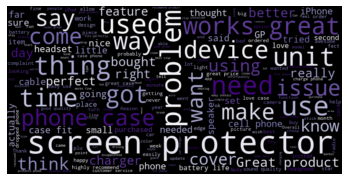

In [29]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Row review_body","review_body","Row","br","a", "about", "above", "above", "across", "after", "afterwards", "again", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "co", "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "no", "nobody",  "noone", "nor", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"])

# Generate a word cloud image
wordcloudwire = WordCloud(width=800, height=400,stopwords=stopwords, background_color="black",colormap="Purples").generate(wire)

plt.imshow(wordcloudwire, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
wordcloudwire.to_file("Wireless.png")

In [31]:
#Software
MOBILE = spark.sql('''
select review_body 
from df_tbl
where product_category = "Mobile_Electronics"
''').collect()

In [32]:
mobile = " ".join(str(review) for review in MOBILE) 
print ("There are {} words in the combination of all review.".format(len(mobile)))

There are 38171635 words in the combination of all review.


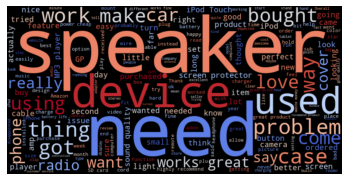

In [34]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["use","unit","time","Row review_body","review_body","Row","br","a", "about", "above", "above", "across", "after", "afterwards", "again", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "co", "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "no", "nobody",  "noone", "nor", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"])


# Generate a word cloud image
wordcloudmobile = WordCloud(width=800, height=400,stopwords=stopwords, background_color="black",colormap="coolwarm").generate(mobile)

plt.imshow(wordcloudmobile, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
wordcloudmobile.to_file("mobile.png")

# Part Four: Sentiment Analysis

In this section, we want to figure out the question that 'Do Amazon star ratings reflect sentiment in reviews'? Due to language barrier, we choose the US market as our target market to perform the analysis.

In [18]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql import functions as f

In [19]:
## add one column showa the length of the review
df1 = df1.withColumn("review_length", f.length("review_body"))

In [20]:
## only foucs on US market
df1 = df1.filter(df1.marketplace == 'US')

df1 = df1.filter(df1.review_length > 0)

In [21]:
## load Sentiment Lexicon
## source: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon
positive = spark.read.format('csv')\
.option('header','false')\
.option('inferSchema', 'true')\
.load("s3://dnsc6278bigdatann/project/positive-words.txt")

negative = spark.read.format('csv')\
.option('header','false')\
.option('inferSchema', 'true')\
.load("s3://dnsc6278bigdatann/project/negative-words.txt")

In [22]:
## denote the positive words as 1; negative words as 0
positive = positive.withColumn("sentiment", lit(1))
negative = negative.withColumn("sentiment", lit(0))

In [23]:
## union positive and negative words
sentiment_df = positive.union(negative)
sentiment_df = sentiment_df.selectExpr("_c0 as word","sentiment as sentiment")

In [24]:
## we will only use "review_id" and "review_body" in sentiment analysis
reviews_df = df1.select(["review_id","review_body"])

## use funtion RegexTokenizer to extract a sequence of words and apply it to our reviews
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("review_body")\
  .setOutputCol("words")
review_words_df = tokenizer.transform(reviews_df)

In [25]:
## join reviews with sentiment
review_word_sentiment_df = review_words_df\
    .select('review_id', f.explode('words').alias('word'))\
    .join(sentiment_df, 'word')

In [26]:
## calculate average the sentiment per review id
sentiment_prediction_df = review_word_sentiment_df\
    .groupBy('review_id')\
    .agg(f.avg('sentiment').alias('avg_sentiment'))\
    .withColumn('predicted_sentiment', f.when(f.col('avg_sentiment') > 0, 1.0).otherwise(0.))

In [27]:
## join sentiment analysis result with amazon dataframe
amazon_sen_df = df1.join(sentiment_prediction_df, 'review_id')

### Explore whehther star rating is in correspondence with sentiment analysis

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


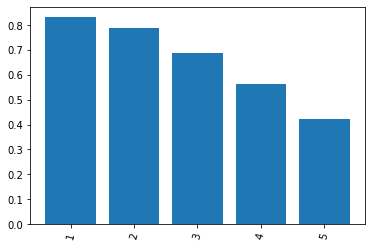

In [51]:
star_rating_df = amazon_sen_df\
                 .groupBy("star_rating")\
                 .agg(f.avg("predicted_sentiment").alias("avg_sentiment"))\
                 .orderBy("star_rating").toPandas()
## plot the result
plt.bar(star_rating_df.star_rating,star_rating_df.avg_sentiment)
plt.xticks(rotation=75)
plt.show()

### Explore what kind of customer tends to give positive review or nagative review

In [50]:
## denote overall whehther this customer tends to give positive review or nagtive review
positive_or_not = amazon_sen_df\
             .groupBy("customer_id")\
             .agg((f.sum("predicted_sentiment")/f.count(amazon_sen_df.customer_id)).alias("percent_positive"))\
             .orderBy("percent_positive",ascending=False)\
             .withColumn('positive_or_not', f.when(f.col('percent_positive') > 0.5, 1.0).otherwise(0.))

In [52]:
## join the two dataframe together
amazon_po_df = positive_or_not.join(amazon_sen_df, 'customer_id',how='left')
## enable the frame to be used in sql code
amazon_po_df.createOrReplaceTempView("amazon_data")

In [53]:
avgstar = spark.sql("""
          SELECT customer_id,avg(star_rating) avg_star
          FROM amazon_data
          GROUP BY customer_id
          """)
avgstar.createOrReplaceTempView("avgstar")

In [54]:
## generate relevant customer information
customer_info = spark.sql("""
          SELECT DISTINCT amazon_data.customer_id,positive_or_not, vine, verified_purchase,avgstar.avg_star
          FROM amazon_data
          JOIN avgstar
          ON amazon_data.customer_id == avgstar.customer_id
          """)

#### Whether people tends to give positive reviews would also give high star rating

In [ ]:
## get the dataframe where people either would like to give positive or negative reviews
positive_cu = spark.sql("""
          SELECT *
          FROM customer_info
          WHERE positive_or_not == 1
          """)
negative_cu = spark.sql("""
          SELECT *
          FROM customer_info
          WHERE positive_or_not == 0
          """)

### Would vine members tends to be positive or negative when they give their reviews

In [ ]:
positive_cu.groupBy("vine")\
           .agg(f.count("vine").alias("count"),(f.count("vine")*100/positive_cu.count()).alias("percent")).show()

In [ ]:
negative_cu.groupBy("vine")\
           .agg(f.count("vine").alias("count"),(f.count("vine")*100/negative_cu.count()).alias("percent")).show()

# Part Five: Modeling

Finally, we decided to building a model that classifies the helpfulness of one review. If the system can figure out whether a review is helpful and put it on top of the [Customer review section] of the amazon website, it will greatly enhance the experience of new customers who want to get the information of the product before they make the purchase.

In [28]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, IndexToString, VectorAssembler, Binarizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [29]:
df2=amazon_sen_df
#create variable help_pct, map null values into 0
df2=df2.withColumn('help_pct',col('helpful_votes')/col('total_votes'))
df2=df2.withColumn("help_pct", when(df2['help_pct'].isNull(),0).otherwise(df2['help_pct']))

In [28]:
df2.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)
 |-- review_length: integer (nullable = true)
 |-- avg_sentiment: double (nullable = true)
 |-- predicted_sentiment: double (nullable = false)
 |-- help_pct: double (nullable = true)



## 5.1 Create the label whether the review is helpful or not

In [30]:
## Values less than or equal to threshold is mapped to 0, else to 1.
help_binarizer = Binarizer(threshold=0, inputCol="help_pct", outputCol="label") 
df2 = help_binarizer.transform(df2)

## 5.2 Encode the string variable with OneHotEncoderIndexer

In [31]:
#ohe_mkt = OneHotEncoderEstimator(inputCols=["marketplace"],outputCols=["mkt_vec"]).setHandleInvalid("skip")

#si_mkt = StringIndexer(inputCol="marketplace", outputCol="mkt_ix").setHandleInvalid("skip")#.fit(df_data)
si_vine = StringIndexer(inputCol="vine", outputCol="vine_ix").setHandleInvalid("skip")
si_verified = StringIndexer(inputCol="verified_purchase", outputCol="verified_ix").setHandleInvalid("skip")

## 5.3 Create a feature vector by combining all string features together usinf the vectorAssembler method

In [32]:
vectorAssembler_features = VectorAssembler(
    inputCols=["vine_ix", "verified_ix","star_rating","avg_sentiment","review_length"], 
    outputCol="features")

## 5.4 Split the dataset into training and testing

In [33]:
splitted_data = df2.randomSplit([0.8, 0.18, 0.02], 24)
train_data = splitted_data[0]
test_data = splitted_data[1]
predict_data = splitted_data[2]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
print("Number of prediction records : " + str(predict_data.count()))

Number of training records: 121790723
Number of testing records : 27401284
Number of prediction records : 3042973


In [33]:
train_data.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)
 |-- review_length: integer (nullable = true)
 |-- avg_sentiment: double (nullable = true)
 |-- predicted_sentiment: double (nullable = false)
 |-- help_pct: double (nullable = true)
 |-- label: double (nullable = true)



## 5.5 Build models with pipelines

### 5.5.1 LogisticRegression

In [26]:
log = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10, regParam=0.01)

In [29]:
pipeline_log = Pipeline(stages=[si_vine, si_verified,
                               vectorAssembler_features, 
                               log])

In [30]:
model_log = pipeline_log.fit(train_data)

In [31]:
predictions_log = model_log.transform(test_data)
evaluatorLog = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy_log = evaluatorLog.evaluate(predictions_log)
print("Logistic Regression Accuracy = %g" % accuracy_log)

Logistic Regression Accuracy = 0.726439


### 5.5.2 Random Forest Classifier

In [34]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [35]:
pipeline_rf= Pipeline(stages=[si_vine, si_verified,
                               vectorAssembler_features, 
                               rf])

In [36]:
model_rf = pipeline_rf.fit(train_data)

In [38]:
predictions_rf = model_rf.transform(test_data)
evaluatorRf = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy_rf = evaluatorRf.evaluate(predictions_rf)

print("Random Forest Accuracy = %g" % accuracy_rf)
#print("Test Error = %g" % (1.0 - accuracy))

Random Forest Accuracy = 0.745301


### 5.5.3 GBTClassifier

In [49]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=5, maxDepth=2, featuresCol="features",labelCol="label", seed=42)

In [50]:
pipeline_gbt= Pipeline(stages=[si_vine, si_verified,
                               vectorAssembler_features, 
                               gbt])

In [53]:
model_gbt = pipeline_gbt.fit(train_data)

In [54]:
predictions_gbt = model_gbt.transform(test_data)
evaluatorGbt = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy_gbt = evaluatorGbt.evaluate(predictions_gbt)

print("Gradient Boosting Tree Accuracy = %g" % accuracy_gbt)
#print("Test Error = %g" % (1.0 - accuracy))

Gradient Boosting Tree Accuracy = 0.741817
